In [2]:
pip install pynapple matplotlib dandi dandischema

Note: you may need to restart the kernel to use updated packages.


# Peri-Event Time Histogram Tutorial 

*Author: Dhruv Mehrotra*


This notebook demonstrates how we use Pynapple on various publicly available datasets in systems neuroscience to streamline analysis. In this notebook, we will examine the dataset from <a href="https://www.nature.com/articles/s41593-022-01020-w" target="_blank">Zheng et al (2022)</a>, which was used to generate Figure 4c in our <a href="https://elifesciences.org/articles/85786" target="_blank">publication</a>. 

The NWB file for the example used here is provided in <a href="https://github.com/PeyracheLab/pynacollada/tree/main/pynacollada/Pynapple%20Paper%20Figures/Zheng%202022/000207/sub-4" target="_blank">this</a> repository. The entire dataset can be downloaded  <a href="https://dandiarchive.org/dandiset/000207/0.220216.0323" target="_blank">here</a>. 

***

**Note:** This tutorial uses seaborn and matplotlib for displaying the figure as well as the dandi package
You can install all with `pip install matplotlib seaborn dandi dandischema`

***

First, import the necessary libraries:

In [1]:
#Import matplotlib.pyplot, numpy, pynapple and seaborn libraries


The next step is to stream the data from the DANDI server. To do so, run the following lines of code:

In [3]:
# Import more libraries
from pynwb import NWBHDF5IO

from dandi.dandiapi import DandiAPIClient
import fsspec
from fsspec.implementations.cached import CachingFileSystem
import h5py

# Enter the session ID and path to the file
dandiset_id, filepath = ("000207", "sub-4/sub-4_ses-4_ecephys.nwb")

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, "draft").get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

# First, create a virtual filesystem based on the http protocol
fs = fsspec.filesystem("http")

# Create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage="nwb-cache",  # Local folder for the cache
)

# Next, open the file
file = h5py.File(fs.open(s3_url, "rb"))
io = NWBHDF5IO(file=file, load_namespaces=True)

/media/DataDhruv/anaconda3/envs/pynapple/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/media/DataDhruv/anaconda3/envs/pynapple/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/media/DataDhruv/anaconda3/envs/pynapple/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Now let's load the data from the Neurodata Without Borders (NWB) file. This is done as follows:

In [4]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

data = nap.NWBFile(io.read())  # Load the NWB file for this dataset

# What does this look like?
print(data)

4
┍━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                     │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                    │ TsGroup     │
│ timediscrimination_table │ IntervalSet │
│ recognition_table        │ IntervalSet │
│ encoding_table           │ IntervalSet │
│ experiment_ids           │ Tsd         │
│ events                   │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


This dataset has several variables of interest. We will first get the spike times and visualize them.

In [1]:
# Get spike timings
spikes = 

# What does this look like?
print(spikes)

SyntaxError: invalid syntax (4265805270.py, line 2)

The spike times TsGroup has, among other information, the mean firing rate of the unit, the X, Y and Z coordinates, the brain region the unit was recorded from, and the channel number on which the unit was located.

Next, let's get the encoding table of all stimulus times:

In [7]:
encoding_table = 

# What does this look like?
print(encoding_table)

/home/dhruv/pynapple_DM/pynapple/io/interface_nwb.py:445: UserWarning: Too many metadata. Returning pandas.DataFrame, not IntervalSet
  data = self._f_eval[self.data[key]["type"]](obj)


    start_time   stop_time  fixcross_time  ExperimentID  boundary1_time  \
id                                                                        
0     1.068463    9.101330       0.056555          70.0        5.068463   
1    10.182342   18.114558       9.116686          70.0       12.880601   
2    19.071072   27.137388      18.130498          70.0       23.071072   
3    28.160476   36.390234      27.154926          70.0       32.160475   
4    37.470909   44.584497      36.409347          70.0       41.470909   
..         ...         ...            ...           ...             ...   
85  892.755233  900.921092     891.747973          70.0      898.284193   
86  901.906850  910.171979     900.940121          70.0      905.906850   
87  911.138396  919.335950     910.190938          70.0      915.138396   
88  920.363950  928.329845     919.354902          70.0      921.906193   
89  930.639635  939.073029     929.718098          70.0      932.997106   

    boundary2_time  boun

This table has, among other things, the scene boundary times for which we will plot the peri-event time histogram (PETH).

There are 3 types of scene boundaries in this data. For the purposes of demonstration, we will use only the "No boundary" (NB) and the "Hard boundary" (HB conditions). The encoding table has a stimCategory field, which tells us the type of boundary corresponding to a given trial.

In [10]:
# Get the scene boundary type for all trials
stimCategory = np.array(encoding_table.stimCategory)

# What does this look like?
print(stimCategory)

[0 1 2 0 0 0 1 0 2 1 2 0 2 0 1 1 1 1 0 0 2 0 0 2 0 1 0 2 0 0 2 0 0 0 0 2 2
 2 0 0 1 1 1 1 0 2 1 1 0 2 1 0 2 2 2 0 1 0 1 1 2 2 0 2 2 2 1 1 2 1 0 2 2 1
 0 1 2 0 2 2 1 1 1 1 2 1 2 2 1 1]


Trials marked 0 correspond to NB, while trials marked 2 correspond to HB. Let's extract the trial numbers for NB and HB trials:

In [19]:
# NB trial indices
indxNB = np.where(stimCategory == 0)  

# HB trial indices
indxHB = np.where(stimCategory == 2)

The encoding table also has 3 types of boundary times. For the purposes of our demonstration, we will focus on boundary1 times, and extract them:

In [13]:
# Get timings of Boundary1
boundary1_time = np.array(encoding_table.boundary1_time)

# What does this look like?
print(boundary1_time)

[  5.06846275  12.88060075  23.071072    32.1604755   41.470909
  49.5747065   56.07442325  72.803867    82.1299925   92.77667275
  99.9925845  109.0787315  118.0778575  133.12435825 140.94827125
 147.8236585  160.726736   170.441769   183.29262575 191.11327175
 199.63382425 208.5142425  217.6186295  232.62687825 241.7270365
 250.58327775 259.5545145  268.6661045  278.026902   287.04517875
 301.2426685  310.21093375 319.1822215  328.13037175 337.16751875
 363.737004   372.785663   381.86749625 391.2704085  400.5077995
 407.28660475 416.0272855  431.792285   441.75272875 448.88401175
 456.97766275 463.88864475 472.13035175 490.53584775 499.7064625
 507.6917495  518.78793775 528.140675   537.1412335  552.5116415
 562.4287995  569.44012625 580.99649325 591.974217   597.74463025
 608.3638655  624.44389125 633.4175285  642.3969695  651.776966
 660.699774   676.9439885  681.3602465  692.799878   699.53861175
 711.341688   720.4819275  729.43782175 772.99961425 780.19490625
 788.1175045  798.

This contains the timings of all boundaries in this block of trials. Note that we also have the type of boundary for each trial. Let's store the NB and HB boundary timings in separate variables, as Pynapple Ts objects:

In [15]:
# NB timings
NB = 

# HB timings
HB = 

Now the analysis can truly begin! 

***

## Peri-Event Time Histogram (PETH)

A PETH is a plot where we align a variable of interest (for example, spikes) to an external event (in this case, to boundary times). This visualization helps us infer relationships between the two.

For our demonstration, we will align the spikes of the first unit, which is located in the hippocampus, to the times of NB and HB. You can do a quick check to verify that the first unit is indeed located in the hippocampus, we leave it to you.

With Pynapple, PETHs can be computed with a single line of code!

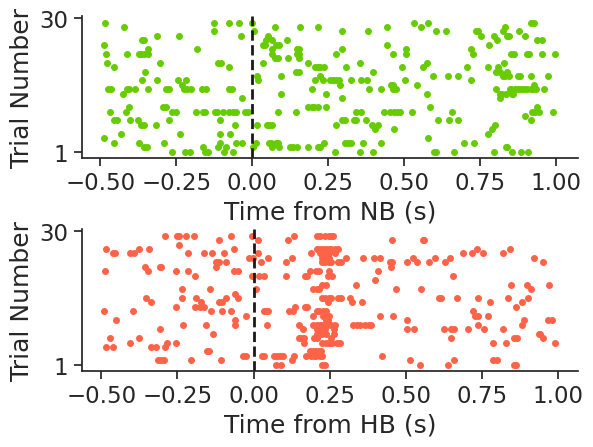

In [17]:
# Compute PETH of unit aligned to NB, for -0.5 to 1s windows
NB_peth = 

# Compute PETH of unit aligned to HB, for -0.5 to 1s windows
HB_peth = 

#Let's plot the PETH


Awesome! From the PETH, we can see that this neuron fires after boundary onset in HB trials. This is an example of what the authors describe  <a href="https://www.nature.com/articles/s41593-022-01020-w" target="_blank">here</a> as a *boundary cell*.

*** 

### PETH of firing rate for NB and HB trials

Now that we have the PETH of spiking, we can go one step further. We will plot the mean firing rate of this cell aligned to the boundary for each trial type. Doing this in Pynapple is very simple!

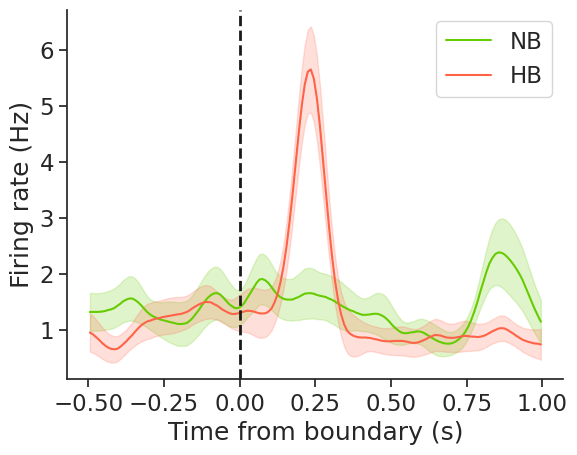

In [18]:
bin_size = 0.2 #200ms bin size
step_size = 0.01 #10ms step size, to make overlapping bins 
winsize = int(bin_size/step_size) #Window size 

#Use Pynapple to compute binned spike counts
counts_NB =                                #Spike counts binned in 10ms steps, for NB trials
counts_HB =                                #Spike counts binned in 10ms steps, for HB trials

#Smoothing binned spike counts using a window of size 20, for both trial types
counts_NB = counts_NB.as_dataframe().rolling(winsize, win_type = 'gaussian', min_periods = 1, center = True, axis = 0).mean(std = 0.2 * winsize) 
counts_HB = counts_HB.as_dataframe().rolling(winsize, win_type = 'gaussian', min_periods = 1, center = True, axis = 0).mean(std = 0.2 * winsize) 

#Compute firing rate for both trial types
fr_NB = counts_NB * winsize
fr_HB = counts_HB * winsize

#Compute the mean firing rate for both trial types 
meanfr_NB = 
meanfr_HB = 

#Compute standard error of mean (SEM) of the firing rate for both trial types
error_NB = 
error_HB = 

#Plot the mean +/- SEM of firing rate for both trial types


This plot verifies what we visualized in the PETH rasters above, that this cell responds to a hard boundary. Hence, it is a *boundary cell*. To learn more about these cells, please check out the original study <a href="https://www.nature.com/articles/s41593-022-01020-w" target="_blank">here</a>. 

I hope this tutorial was helpful. If you have any questions, comments or suggestions, please feel free to reach out to the Pynapple Team!